In [3]:
import pandas as pd
import numpy as np
import seaborn as sns


In [4]:

'''Drops nan values and positive or negative infinity'''
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

Clean our data and then we seperate our data into features and labels

In [33]:
rhp = pd.read_csv('rhp.csv')
rhp.drop(['PitcherThrows'], inplace=True, axis=1)
rhp = clean_dataset(rhp)


A = rhp.to_numpy()   
A = A.astype('float64')  

X_all = A[:,0:17]  # X (features) ... is all rows, columns 0, 1, 2, 3
y_all = A[:,17] 




In [34]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=47)


In [35]:
from sklearn import tree      # for decision trees

best_depth = 1   # we don't know what depth to use, so let's guess 1
dtree_model = tree.DecisionTreeClassifier(max_depth=best_depth)

dtree_model.fit(X_train, y_train)                            

Created and trained a DT classifier with max depth = 1


Next with the use of graphviz we can see what the decision tree with depth 1 looks like.

Index(['RelSpeed', 'SpinRate', 'RelHeight', 'ZoneSpeed', 'ZoneTime',
       'Extension', 'VertRelAngle', 'HorzRelAngle', 'SpinAxis', 'RelSide',
       'VertBreak', 'InducedVertBreak', 'HorzBreak', 'PlateLocHeight',
       'PlateLocSide', 'VertApprAngle', 'HorzApprAngle', 'TaggedPitchNum'],
      dtype='object')
file tree_data.gv written. Try pasting its contents to  http://viz-js.com/


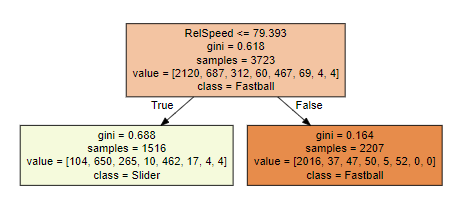

In [39]:
label = ['Fastball','Slider','ChangeUp','Cutter','Curveball','Sinker','Splitter','Other']

label_index = {}
for i, name in enumerate(label):
    label_index[name] = i


filename = 'tree_data.gv' 

COLUMNS = rhp.columns
print(COLUMNS)   

tree.export_graphviz(dtree_model, out_file=filename,  # the filename constructed above...!
                            feature_names=COLUMNS[:-1], # actual feature names, not species
                            filled=True,              
                            rotate=False,             # False for Up/Down; True for L/R
                            class_names= label,      # good to have   
                            leaves_parallel=True )    # lots of options!

print(f"file {filename} written. Try pasting its contents to  http://viz-js.com/")


# with open(filename, "r") as f:
#     all_file_text = f.read()
#     print(all_file_text)

from IPython import display
display.Image("./tree1.png")

For further testing we need cross validation frim sklearn. This will allow us to test the accuracy of the data

In [40]:
from sklearn.model_selection import cross_val_score



best_d = 1
best_accuracy = 0.0

for d in range(1,6):
    cv_model = tree.DecisionTreeClassifier(max_depth=d)   # for each depth, d
    cv_scores = cross_val_score( cv_model, X_train, y_train, cv=5 ) # 5 means 80/20 split
    
    average_cv_accuracy = cv_scores.mean()  # more likely, only their average
    print(f"depth: {d:2d}  cv accuracy: {average_cv_accuracy:7.4f}")
    
    if average_cv_accuracy > best_accuracy:
        best_accuracy = average_cv_accuracy
        best_d = d

    
    
# assign best value of d to best_depth
best_depth = best_d   # may have to hand-tune this, depending on what happens...
print()
print(f"best_depth = {best_depth} is our choice for an underfitting/overfitting balance.")  

C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  1  cv accuracy:  0.7150


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  2  cv accuracy:  0.7827


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  3  cv accuracy:  0.8721


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  4  cv accuracy:  0.8732


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  5  cv accuracy:  0.8877

best_depth = 5 is our choice for an underfitting/overfitting balance.


It is not a surprise 5 is the best depth, but we would like for our tree to be more general. After a depth of 3 the accuracy only increases by a point or two so we will use 3 as our best depth and retrain a model and see what that tree looks like.

In [43]:
best_depth = 3

dtree_model = tree.DecisionTreeClassifier(max_depth=best_depth)

dtree_model.fit(X_train, y_train)                          

DecisionTreeClassifier(max_depth=3)

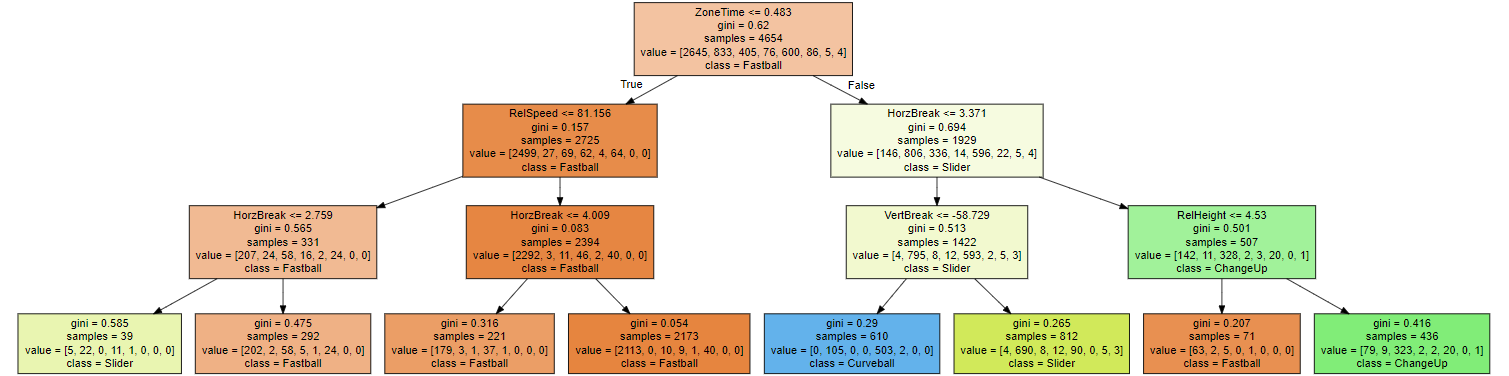

In [54]:
# filename = 'tree_data_d3.gv'    # sometimes .dot is used, instead of .gv

# tree.export_graphviz(dtree_model, out_file=filename,  # the filename constructed above...!
#                             feature_names=COLUMNS[:-1], # actual feature names, not species
#                             filled=True,              # fun!
#                             rotate=False,             # False for Up/Down; True for L/R
#                             class_names=label,      # good to have   
#                             leaves_parallel=True )    # lots of options!

# print(f"file {filename} written. Try pasting its contents to  http://viz-js.com/")

# with open(filename, "r") as f:
#     all_file_text = f.read()
#     print(all_file_text)

display.Image("./tree3.png")

Next we show how much each feature is contributing to the decision making.

In [55]:
dtree_model_3 = tree.DecisionTreeClassifier(max_depth=best_depth)



# we train the model (it's one line!)
dtree_model_3.fit(X_all, y_all) 


x = rhp.copy()
x = x.drop('TaggedPitchNum' , axis =1)
columns = x.columns
columns


IMPs = dtree_model_3.feature_importances_

# enumerate is great when you want indices _and_ elements!
for i, importance in enumerate(IMPs):
    perc = importance*100
    print(f"Feature {columns[i]:>12s} has {perc:>7.2f}% of the decision-making importance.")

Feature     RelSpeed has    2.21% of the decision-making importance.
Feature     SpinRate has    0.00% of the decision-making importance.
Feature    RelHeight has    2.98% of the decision-making importance.
Feature    ZoneSpeed has    0.00% of the decision-making importance.
Feature     ZoneTime has   57.46% of the decision-making importance.
Feature    Extension has    0.00% of the decision-making importance.
Feature VertRelAngle has    0.00% of the decision-making importance.
Feature HorzRelAngle has    0.00% of the decision-making importance.
Feature     SpinAxis has    0.00% of the decision-making importance.
Feature      RelSide has    0.00% of the decision-making importance.
Feature    VertBreak has   17.32% of the decision-making importance.
Feature InducedVertBreak has    0.00% of the decision-making importance.
Feature    HorzBreak has   20.03% of the decision-making importance.
Feature PlateLocHeight has    0.00% of the decision-making importance.
Feature PlateLocSide has    

In [57]:
predicted_labels = dtree_model_3.predict(X_test)
actual_labels = y_test

num_correct = sum(predicted_labels == actual_labels)
total = len(actual_labels)
print(f"\nResults on test set:  {num_correct} correct out of {total} total.")


Results on test set:  826 correct out of 931 total.


##### Takeaway
I was surprised to see this as the results because zone time has such a big effect on classification. I think this is intuitive though because it is a very similar metric to release speed which for me would be a huge identifying factor. It is encouraging to see that it scores 826/931, I think the focus on only 3 features is a weakness however.

##### Random Forest
Let's continue this investigation but now with random forests

In [58]:
from sklearn import tree      # for decision trees
from sklearn import ensemble  # for random forests, an ensemble classifier

best_d = 1            # we don't know what depth to use, so we guess...
best_num_trees = 40   # again, we guess
rforest_model = ensemble.RandomForestClassifier(max_depth=best_d, 
                                                n_estimators=best_num_trees,
                                                max_samples=0.5)  
# This max_samples=0.5 is the fraction of rows to use for each DT 
# For all of our forests, we will let max_samples be 0.5   We'll explore best_d and best_num_trees...

# we train the model (again, one line):
rforest_model.fit(X_train, y_train)                              # yay!  trained!
print(f"Built an RF with depth={best_d} and number of trees={best_num_trees}") 

Built an RF with depth=1 and number of trees=40


In [61]:
# Make a better comparison 

def compare_labels(predicted_labels, actual_labels):
    NUM_LABELS = len(predicted_labels)
    num_correct = 0
    
    for i in range(NUM_LABELS):
        p = int(round(predicted_labels[i]))         # round protects from fp error 
        a = int(round(actual_labels[i]))
        result = "incorrect"
        if p == a:  # if they match,
            result = ""       # no longer incorrect
            num_correct += 1  # and we count a match!

        print(f"row {i:>3d} : {label[p]:>12s} {label[a]:<12s}   {result}")   

    print()
    print("Correct:", num_correct, "out of", NUM_LABELS)
    return num_correct

predicted_labels = rforest_model.predict(X_test)
actual_labels = y_test



# And, some overall results
num_correct = sum(predicted_labels == actual_labels)
total = len(actual_labels)
print(f"\nResults on test set:  {num_correct} correct out of {total} total.")

# and, let's print our table, too...
compare_labels(predicted_labels,actual_labels)


Results on test set:  653 correct out of 931 total.
row   0 :     Fastball Fastball       
row   1 :     Fastball Fastball       
row   2 :     Fastball Fastball       
row   3 :     Fastball Fastball       
row   4 :       Slider Slider         
row   5 :     Fastball Fastball       
row   6 :     Fastball Fastball       
row   7 :     Fastball Fastball       
row   8 :       Slider Curveball      incorrect
row   9 :     Fastball Fastball       
row  10 :     Fastball Fastball       
row  11 :     Fastball Slider         incorrect
row  12 :     Fastball Fastball       
row  13 :     Fastball Fastball       
row  14 :     Fastball Fastball       
row  15 :     Fastball Fastball       
row  16 :       Slider Slider         
row  17 :     Fastball Fastball       
row  18 :     Fastball Fastball       
row  19 :     Fastball Fastball       
row  20 :     Fastball Fastball       
row  21 :       Slider Slider         
row  22 :     Fastball Fastball       
row  23 :       Slider Curveball

653

In [62]:

#
# So, to compare different parameters, let's use cv
#

from sklearn.model_selection import cross_val_score



best_d, best_ntrees = 1, 50  
best_score = 0

for d in range(1,6):
    for ntrees in range(50,300,100):
        rforest_model = ensemble.RandomForestClassifier(max_depth=d, 
                                                        n_estimators=ntrees,
                                                        max_samples=0.5)
        cv_scores = cross_val_score( rforest_model, X_train, y_train, cv=5 ) 
        average_cv_accuracy = cv_scores.mean()  
        if average_cv_accuracy > best_score:
            best_score = average_cv_accuracy
            best_d, best_ntrees = d, ntrees
        print(f"depth: {d:2d} ntrees: {ntrees:3d} cv accuracy: {average_cv_accuracy:7.4f}")


best_depth = best_d   
best_num_trees = best_ntrees


print()
print(f"best_depth: {best_depth} and best_num_trees: {best_num_trees} are our choices.")  



C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  1 ntrees:  50 cv accuracy:  0.7373


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  1 ntrees: 150 cv accuracy:  0.7387


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  1 ntrees: 250 cv accuracy:  0.7387


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  2 ntrees:  50 cv accuracy:  0.8681


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  2 ntrees: 150 cv accuracy:  0.8713


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  2 ntrees: 250 cv accuracy:  0.8730


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  3 ntrees:  50 cv accuracy:  0.8807


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  3 ntrees: 150 cv accuracy:  0.8818
depth:  3 ntrees: 250 cv accuracy:  0.8810


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  4 ntrees:  50 cv accuracy:  0.8915


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  4 ntrees: 150 cv accuracy:  0.8915


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  4 ntrees: 250 cv accuracy:  0.8912


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  5 ntrees:  50 cv accuracy:  0.8958


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  5 ntrees: 150 cv accuracy:  0.8969


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


depth:  5 ntrees: 250 cv accuracy:  0.8955

best_depth: 5 and best_num_trees: 150 are our choices.


From the results the forest is more accurate which is expected. I think the best depth is still 3 and the size of the forest at 150 is enough to get a contribution from all the data. 

In [66]:
best_depth = 3 
best_num_trees = 150


rforest_model_final = ensemble.RandomForestClassifier(max_depth=best_depth, n_estimators=best_num_trees,
                                                    max_samples=0.5)



columns =rhp.columns[:-1]

# we train the model (it's one line!)
rforest_model_final.fit(X_all, y_all)              # yay!  trained!
print(f"Built an RF classifier with depth={best_depth} and ntrees={best_num_trees}") 
# let's see them with each feature name:
IMPs = rforest_model_final.feature_importances_

cv_scores = cross_val_score( rforest_model_final, X_train, y_train, cv=5 ) 
average_cv_accuracy = cv_scores.mean()

predicted_labels = rforest_model_final.predict(X_test)
actual_labels = y_test



# And, some overall results
num_correct = sum(predicted_labels == actual_labels)
total = len(actual_labels)
print(f"\nResults on test set:  {num_correct} correct out of {total} total.")

print(f'accuracy: {average_cv_accuracy}') 

# enumerate is great when you want indices _and_ elements!
for i, importance in enumerate(IMPs):
    perc = importance*100
    print(f"Feature {columns[i]:>12s} has {perc:>7.2f}% of the decision-making importance.")




Built an RF classifier with depth=3 and ntrees=150


C:\Users\jvw42\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



Results on test set:  827 correct out of 931 total.
accuracy: 0.8802056722234249
Feature     RelSpeed has   20.18% of the decision-making importance.
Feature     SpinRate has    2.66% of the decision-making importance.
Feature    RelHeight has    0.73% of the decision-making importance.
Feature    ZoneSpeed has    9.20% of the decision-making importance.
Feature     ZoneTime has   16.75% of the decision-making importance.
Feature    Extension has    0.06% of the decision-making importance.
Feature VertRelAngle has    0.60% of the decision-making importance.
Feature HorzRelAngle has    0.34% of the decision-making importance.
Feature     SpinAxis has   11.86% of the decision-making importance.
Feature      RelSide has    0.10% of the decision-making importance.
Feature    VertBreak has   12.59% of the decision-making importance.
Feature InducedVertBreak has    8.08% of the decision-making importance.
Feature    HorzBreak has   13.48% of the decision-making importance.
Feature PlateLocH

#### Final Thoughts

As a person with experience playing baseball and understanding different pitches and how they are meant to move and spin, I find the decision trees above to be pretty intuitive. 

##### Tree
From the tree test with a depth of 3, I think checking the speed of a pitch first is a great indicator and next considering the horizontal and vertical break is a logical progression. All in all I am pleased the tree chose the features it did considering we gave it 17 different features to consider.

The limitations/strength of this tree is that it only predicts either fastball, slider, changeup, or curveball. This is a limitation because the dataset included about 7 different pitch types, but this is also a strength becasue the most common pitches are these 4 so the model is still staying quite general. I'm sure with more depth the tree could guess a different variety of pitches

##### Random Forest

I am very pleased to see that the random forest model did much better than the decision tree model. This makes sense as the random forest gets a better view of all of the data and can be more flexible and recognize edge case pitches. What I liked to see was that the random forest was considering more features as important:   

Feature     RelSpeed has   20.18% of the decision-making importance.     
Feature     SpinRate has    2.66% of the decision-making importance.    
Feature    ZoneSpeed has    9.20% of the decision-making importance.   
Feature     ZoneTime has   16.75% of the decision-making importance.   
Feature     SpinAxis has   11.86% of the decision-making importance.   
Feature    VertBreak has   12.59% of the decision-making importance.   
Feature InducedVertBreak has    8.08% of the decision-making importance.    
Feature    HorzBreak has   13.48% of the decision-making importance.    
Feature VertApprAngle has    2.76% of the decision-making importance.    


Whereas the decision relied heavily on only 3 features:    
Feature     ZoneTime has   57.46% of the decision-making importance.     
Feature    VertBreak has   17.32% of the decision-making importance.    
Feature    HorzBreak has   20.03% of the decision-making importance.    

All in all, I wasn't expecting a decision tree to perform this well. I think it works so well because the dataset is imbalanced with fastballs appearing by far the most. Perhaps if we try to balance out the dataset it will fail more, or maybe it will learn to predict other pitches more often. 

